## Analysis of complex multidimensional stochastic dynamics with optimal coordinates and free energy landscapes.

One way to analyze complex multidimensional stochastic dynamics is to project it on a single coordinate, which often named as an index, progress variable, order parameter, reaction coordinate (RC). There are numerous examples from everyday life and science. The Dow-Jones index is used to describe dynamics of the stock market. The gross domestic product (GDP) or the gross national product (GNP) are used to describe the state of national economy. Temperature is often used to detect an illness in a patient. Marks or grades are used as proxies to assess the knowledge of a student. H-index, a citation index, is used to measure the productivity of a scientist. Reaction coordinates are used to describe the progress of a reaction.

The idea of such a description with a single coordinate or an index is that, it is much easier to visualize the dynamics of a single coordinate, i.e., just plot it as a function of time, and a suitable chosen coordinate can show us how the dynamics progresses. It is clear that when just a single coordinate is used, a lot of information about the original dynamics is inevitably lost. The hope is that if we chose our coordinate carefully, or optimally, the lost information may not be very important. In the best case one hopes that, just by observing the current dynamics of such an optimally selected coordinate, one can predict the future state of the dynamics.

Unfortunately, in many practical cases, the simplicity of computing such coordinates or indexes is of main importance, which results in coordinates that provide a rather poor description of dynamics (examples are many indexes used in practice, e.g., Dow-Jones, GDP,  h-index). It is of interest to determine such coordinates which provide the best possible description of given dynamics, i.e., the optimal coordinates. For an important practical case of reaction dynamics between two given states, e.g., protein folding, the committor function is such an optimal coordinate. It equals the probability of reaching one state (folded) before the other state (unfolded) starting from current position. Methods have been developed to determine the committor, based on a large collection (ensemble) of dynamical trajectories, without knowing the equations of dynamics.

As an example, consider the usage of the committor RC in application to the analysis of disease/patient dynamics. Assume that one can measure the state of a patient (temperature, metabolome, proteome, etc) for some time, i.e., in a course of a few days. or months or even years. And that such longitudinal data have been collected for a relatively large cohort of patients. Then, using the developed methods one should be able to compute/predict the committor function, which in this case is the likelihood of the patient to be cured, arguably the most important characteristics. This can be done without knowing the mechanism of the disease.

Below, we illustrate the analysis of complex dynamics with RC, using a protein folding trajectory as an example. 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="The raw code for this Python notebook is by default hidden for easier reading. Click here to toggle on/off the raw code."></form>''')

#### Analysis of a protein folding trajectory.
We consider an equilibrium folding trajectory of 2f4k protein compute by D. Shaw and coworkers. The original trajectory contains 1509392 frames of molecular dynamics simulation of the protein saved with time interval of 0.2 ns, simulated at $T=380K$. The protein consists of 577 atoms. During this long trajectory the protein repeatedly folds and unfolds around hundred times. Our aim is to analyze this process. One can not visualize the entire trajectory as it is very high-dimensional (577x3 dimensions).

To save space here we consider 1000 first frames.  The trajectory contains X, Y, Z positions of each atoms for each frame, or in other words it contains X, Y, Z positions of atoms as functions of time. 

The trajectory is contained in an array with shape

In [2]:
# load the XYZ data
import numpy as np
xyz=np.load('2f4k.xyz.npz')['xyz']
print (xyz.shape)

(577, 3, 1000)


meaning 577 atoms, 3 coordinates X Y Z, and 1000 frames.

For example, as simplest coordinates, one can visualize how atomic positions changes with time. Fig. below shows time-series of XYZ positions of the first atoms.

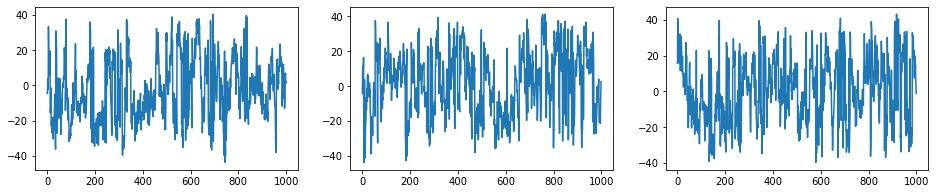

In [3]:
import matplotlib.pyplot as plt

fig,axes=plt.subplots(1,3,figsize=(16,3))
axes[0].plot(xyz[0,0,:])
axes[1].plot(xyz[0,1,:])
_=axes[2].plot(xyz[0,2,:])

The coordinates show stationary fluctuations, they do not exhibit a two state behavior, which is expected if we want to describe protein folding: the protein stays in one state (say unfolded) for some time and then quickly transits to the other state (say folded) then back and so on.

The XYZ coordinate of other atoms show similar picture of stationary fluctuation with no two state behavior. Here we show that of 100-th atom.

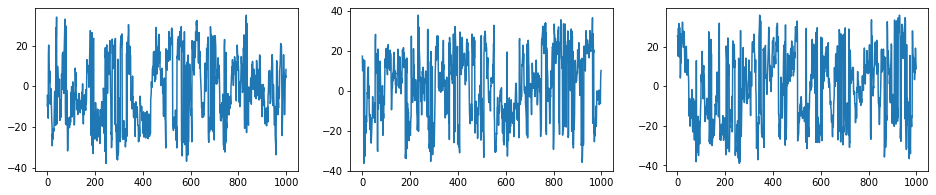

In [4]:
fig,axes=plt.subplots(1,3,figsize=(16,3))
axes[0].plot(xyz[99,0,:])
axes[1].plot(xyz[99,1,:])
_=axes[2].plot(xyz[99,2,:])

This figure does not describe folding either. The explanation is that the absolute positions of atoms are meaningless, as arbitrary translations and rotations dont change the shape of the protein, while they do change the positions. 
One should consider relative position of atoms with respect to each other, for example, distances between them. 

Fig below shows distance time-series between selected atom pairs. The first two distance (that between atoms 1 and 301 and that between atoms 
1 and 401) are not very much different from coordinate time-series considered above. However, luckily, distance between atoms 101 and 401 shows the desired two-state behavior; the trajectory switches between the two regions with low and high values of the distance: its value for frames before ~700th fluctuate around ~8, while that after fluctuate around ~4. It is likely that these two regions correspond to the unfolded and folded state. In the first one the protein is extended, while in the second it is compact.

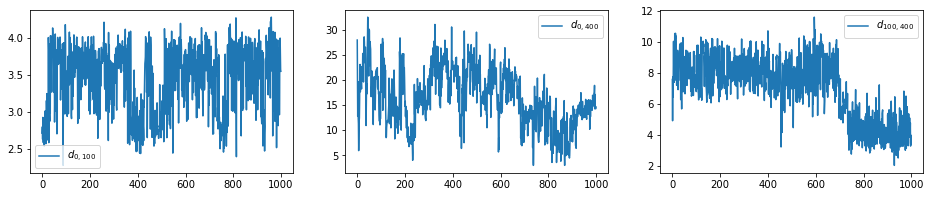

In [5]:
def rij(i,j,xyz):
    dr=xyz[i,:,:]-xyz[j,:,:]
    dr2=np.sum(dr*dr,axis=0)
    dr=np.sqrt(dr2)
    return dr

fig,axes=plt.subplots(1,3,figsize=(16,3))

axes[0].plot(rij(0,300,xyz),label='$d_{0,100}$')
axes[1].plot(rij(0,400,xyz),label='$d_{0,400}$')
axes[2].plot(rij(100,400,xyz),label='$d_{100,400}$')

for ax in axes:_=ax.legend()


Thus a good RC can be used to describe/detect changes in the dynamics, here folding. You can experiment with the other pairs of atoms to see if you can find a better RC. Do you know what makes a RC a better RC? 

Usually a poor RC leads to smoother, simpler free energy landscape with smaller barriers and faster kinetics. Thus, roughly speaking, the best RC should have complex free energy landscape with the highest barriers and slowest kinetics. Lets discuss how one can determine a free energy landscape. 

The original trajectory is more than 1500 times longer than the one we visualized above. Thus it is rather difficult to analyze the entire trajectory by visualizing its time-series - the plot should be 1500 longer. An alternative is to determine and depict a related quantity - the free energy landscape as a function of the RC. In order to do that one first constructs a histogram, which is proportional to the probability of finding the trajectory in the bin, by counting how many time the trajectory has visited a particular bin. Taking the negative logarithm gives the dimensionless free energy $F(x)/kT=-\ln P(x)$, here $k$ is the Boltzmann constant and $T$ is the temperature.

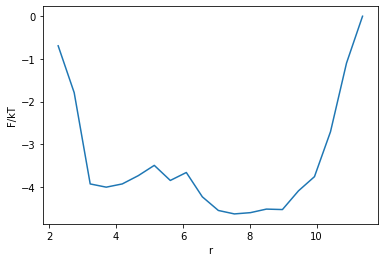

In [6]:
def fep(r,nb=20,xlabel='r'):
    hist,bins=np.histogram(r,nb)
    centers=(bins[:-1]+bins[1:])/2
    f=-np.log(np.maximum(hist,1))
    plt.plot(centers,f)
    plt.xlabel(xlabel)
    plt.ylabel('F/kT')
fep(rij(100,400,xyz))

The free energy profile as a function of the RC shows two minima $3<r<4$ and $7<r<10$ separated by a barrier $5<r<6$. The minima corresponds to the two states observed in the time-series plot. The lower is the free energy the more likely it is to find the system in that region. Thus the system/protein spends most of its time in the minima, and infrequently at the barriers, during transitions between the minima. 

In general, if the RC is rather good, then system dynamics can be approximated by diffusion on the free energy landscape with position dependent diffusion coefficient. The later determines how quickly the system moves/diffuses on the landscape.

The barrier here is not that high, which is explained by the fact that the employed distance is a rather poor RC. As we see below a better RC shows more minima and higher barriers. Poor RC generally result in simplified free energy landscapes with missing minima and low barriers.

Once the free energy landscape has been constructed and states of interests have been identified, one can analyze the properties of the minima or states. For example, for protein folding, the 3D structures, which the protein adopts in each of the states, are of interest. One can use the change of structures to understand how the protein folds. One way to inspect the structures is to select a number of frames that belong to each state and visualize their 3D structures using, say, the PyMol software.

For example, assume that we are interested in the structures of the transition state (TS), the state, corresponding to the highest point of the folding free energy barrier, separating the folded and unfolded states.  Looking at the free energy profile we see that the top of the barrier is around $r\sim 5$. Next we need to find frames that have $r\sim 5$. To do that we closely inspect the time-series of the RC in the region, where it transits from one state to the other; we focus on frames in the range 680-750 (see figure below). As frame with $r\sim 5$ one can take frame number 735. Note that due to the suboptimal RC it is difficult to select TS frames unambiguously, as there are many overlapping regions. In this case it is likely that frames in the range 700-730, where the RC fluctuate around some value describe an intermediate state and the actual folding transition happens afterwards. Having determined the desired frame number one can use programs like WORDOM to extract pdb files from the trajectory, the later can be visualized with PyMol.

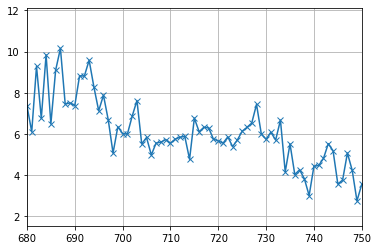

In [7]:
plt.plot(rij(100,400,xyz),'x-')
plt.xlim(680,750)
plt.grid()

#### Conventional/standard reaction coordinates in protein folding

A distance between two atoms is an example of the simplest RC. A number of physically based RC are often used in description of protein folding. The root mean squared distance from the native structure (rmsd), which measures the distance between the current and the native structures. It is large for the denatured/unfolded state and small for the native state. The fraction of native contact $Q$ measures the fraction of contacts between atoms/residues in the native structure that preserved in the current structure. The larger the fraction the more similar structure is to the native. These are examples of relatively simple RC which are easy to compute, but which are often appears to be suboptimal. The committor function $q$ is the optimal RC for protein folding. Free energy landscape as a function of this coordinate provides accurate description of folding dynamics and can be used to compute many important properties of the dynamics exactly. Below we show free energy landscapes as functions of $Q$ and $q$, computed from the entire trajectory. As one can see $F(q)$ landscape has more details with more minima and much higher barriers. For example one can see that denatured and native states contain a few sub-basins.

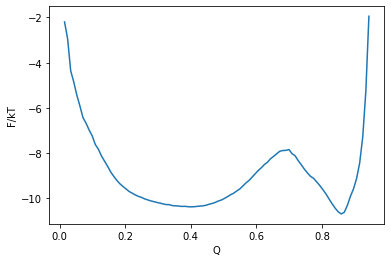

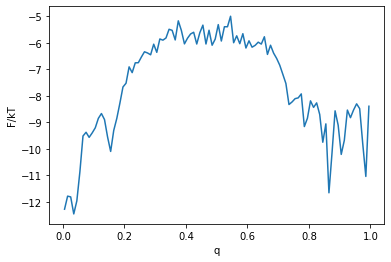

In [8]:
Q=np.load('2f4k.npz')['Q']
q=np.load('2f4k.npz')['q']

fep(Q,100,'Q')
plt.show()
fep(q,100,'q')


### In summary, 

here we have provided an introduction into how reaction coordinates or indexes can be used to describe/analyze complex dynamics. How the associated free energy landscapes can be used to provide an intuitive picture of the dynamics as diffusion on the free energy landscape. How, one can determine the structural properties of the different regions of the free energy landscapes.

More detailed discussion of the framework of reaction coordinates, free energy landscapes and  cut profiles and the description of the dynamcis with their help is provided in the CFEP notebooks. There, in particular, one can read about how to compute the position dependent diffusion coefficient and the resulting rate, or how to validate/inspect whether a putative RC is optimal.